## Red neuronal recurrente desde cero.

Fuente: https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Generamos una "serie de tiempo"

In [37]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)]) + np.random.rand(200)

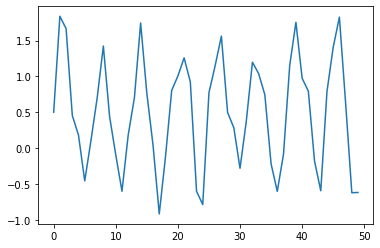

In [38]:
plt.plot(sin_wave[:50])

In [39]:
len(sin_wave), sin_wave.shape

(200, (200,))

### Guardamos algunos intervalos de tiempo X(t)

In [40]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len #150

for i in range(num_records - 50): #100
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X[i], Y[i]))
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

it: 0 | X:[ 0.50084068  1.83897658  1.66637626  0.45653639  0.18038794 -0.45629743
  0.10422505  0.69873241  1.42377452  0.44273464 -0.09558527 -0.60058618
  0.18312143  0.70430822  1.74490712  0.76387098  0.03976645 -0.91630695
 -0.12225499  0.80459332  1.00665087  1.25893713  0.92442498 -0.59988243
 -0.78569988  0.77348091  1.15104208  1.56177754  0.4979544   0.28592513
 -0.28020344  0.36676167  1.1981599   1.03911824  0.74395024 -0.21728999
 -0.60229864 -0.08445586  1.15145102  1.7545762   0.97522474  0.79532037
 -0.18158717 -0.59349872  0.78953086  1.40597778  1.82655551  0.63012088
 -0.62121837 -0.61751904] | Y:-0.01260841447345551
it: 1 | X:[ 1.83897658  1.66637626  0.45653639  0.18038794 -0.45629743  0.10422505
  0.69873241  1.42377452  0.44273464 -0.09558527 -0.60058618  0.18312143
  0.70430822  1.74490712  0.76387098  0.03976645 -0.91630695 -0.12225499
  0.80459332  1.00665087  1.25893713  0.92442498 -0.59988243 -0.78569988
  0.77348091  1.15104208  1.56177754  0.4979544   0.2

In [41]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

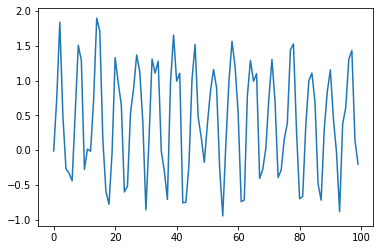

In [42]:
plt.plot(Y)

### Creamos un conjunto de validación

In [43]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X_val[i-100], Y_val[i-100]))
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

it: 100 | X:[ 0.37351764  0.84717725  1.16098205  0.89304891 -0.26752696 -0.94603825
  0.08122171  0.98268881  1.56451692  1.20588184  0.53522001 -0.74221071
 -0.71719995  0.77962653  1.2910365   0.99242265  1.09772334 -0.40625657
 -0.27781685  0.02349805  0.74313137  1.30418977  0.70137851 -0.39289413
 -0.28675147  0.15759825  0.38576041  1.44301127  1.5269813   0.2620488
 -0.69917775 -0.66570003  0.35230724  0.99698532  1.10894767  0.69235814
 -0.48517738 -0.71942083  0.29360541  0.84145217  1.15399003  0.4469092
 -0.03329047 -0.8856175   0.37529184  0.6105268   1.30875377  1.43167941
  0.14334707 -0.20040855] | Y:-0.32313142124923877
it: 101 | X:[ 0.84717725  1.16098205  0.89304891 -0.26752696 -0.94603825  0.08122171
  0.98268881  1.56451692  1.20588184  0.53522001 -0.74221071 -0.71719995
  0.77962653  1.2910365   0.99242265  1.09772334 -0.40625657 -0.27781685
  0.02349805  0.74313137  1.30418977  0.70137851 -0.39289413 -0.28675147
  0.15759825  0.38576041  1.44301127  1.5269813   0

## Arquitectura de la RNN

In [44]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # largo de la secuencia
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

### Matrices de Pesos:

 - U es la matriz de pesos para los pesos entre la entrada y las capas ocultas.
 - V es la matriz de pesos para los pesos entre las capas ocultas y las de salida.
 - W es la matriz de pesos para los pesos compartidos en la capa oculta, la capa recurrente propia de las RNNs.

In [45]:
U = np.random.uniform(0, 1, (hidden_dim, T))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))

### Función de activación:

In [46]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Entrenamiento
```
for epocas 
    for secuence in Y
        for element in secuence
```

In [47]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[133666.60208751]] , Val Loss:  [[66605.03633796]]
Epoch:  2 , Loss:  [[86967.93412009]] , Val Loss:  [[43300.11396915]]
Epoch:  3 , Loss:  [[50269.26615252]] , Val Loss:  [[24995.19160027]]
Epoch:  4 , Loss:  [[23570.59681169]] , Val Loss:  [[11690.26857619]]
Epoch:  5 , Loss:  [[6867.24340745]] , Val Loss:  [[3383.2194595]]
Epoch:  6 , Loss:  [[102.94109526]] , Val Loss:  [[49.19433484]]
Epoch:  7 , Loss:  [[34.95856114]] , Val Loss:  [[18.99085203]]
Epoch:  8 , Loss:  [[35.12865896]] , Val Loss:  [[19.12779795]]
Epoch:  9 , Loss:  [[35.13031307]] , Val Loss:  [[19.14469268]]
Epoch:  10 , Loss:  [[35.0338239]] , Val Loss:  [[19.21919684]]
Epoch:  11 , Loss:  [[35.13368975]] , Val Loss:  [[19.2947073]]
Epoch:  12 , Loss:  [[34.95665994]] , Val Loss:  [[19.06924838]]
Epoch:  13 , Loss:  [[34.96880147]] , Val Loss:  [[19.22912306]]
Epoch:  14 , Loss:  [[34.81351456]] , Val Loss:  [[19.02519915]]
Epoch:  15 , Loss:  [[34.95187602]] , Val Loss:  [[18.98396703]]
Epoch: 

In [48]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

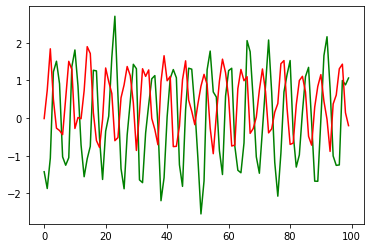

In [49]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

### Ahora en el conjunto de validación

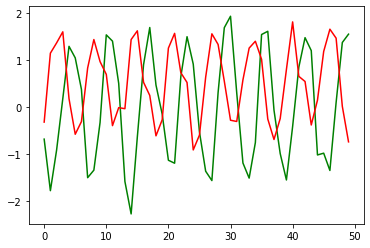

In [50]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_val[:, 0], preds[:, 0, 0])

3.2401227844157274

### Comparando con una red MLP de tensorflow

In [52]:
import tensorflow.keras as K

In [53]:
numNeurons = 100
model = K.models.Sequential([
    K.layers.Dense(numNeurons, activation='relu', input_shape=(50,)),
    K.layers.Dense(1, activation='linear')
    # 
    
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(X[:,:,0],
                    Y,
                    validation_data=(X_val[:,:,0],
                                     Y_val),
                    epochs=20, batch_size=16)  

Epoch 1/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4519 - val_loss: 0.1442
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1453 - val_loss: 0.1726
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.1504 - val_loss: 0.1200
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1107 - val_loss: 0.1463
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1405
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.1420
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0858 - val_loss: 0.1188
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0781 - val_loss: 0.1189
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0767 - val_loss: 0.1430
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0672 - val_loss: 0.1207
Epoch 11/20
7/7 [=====================

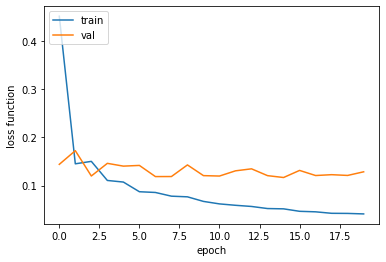

In [55]:
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
# plt.title('model loss function: {:.3} min'.format(timef))
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [59]:
preds = model.predict(X_val[:,:,0])
preds.shape, Y_val.shape, X_val[:,:,0].shape

2/2 [==============================] - 0s 1ms/step


((50, 1), (50, 1), (50, 50))

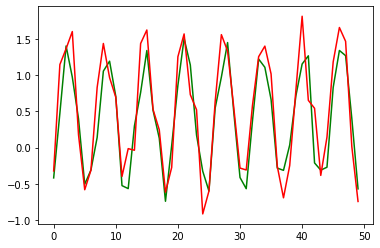

In [61]:
plt.plot(preds, 'g')
plt.plot(Y_val, 'r')
plt.show()